In [50]:
library("dplyr")
library("Seurat")
library("patchwork")
library("ggplot2")
library("clustree")

In [51]:
day1.data = Read10X(data.dir = "../Day1/filtered_feature_bc_matrix/")

day1_Seurat1 = CreateSeuratObject(counts = day1.data, project = "Day1", min.cells = 3, min.features = 2000)
print(day1_Seurat1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
19471 features across 1941 samples within 1 assay 
Active assay: RNA (19471 features, 0 variable features)
 1 layer present: counts


In [52]:
head(day1_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA
,<fct>,<dbl>,<int>
AAACCCATCGCTATTT-1,Day1,5030,2035
AAACGAAAGGAAACGA-1,Day1,15383,4088
AAACGAAAGTAAACTG-1,Day1,36686,7059
AAACGAAGTAACTTCG-1,Day1,6858,2330
AAACGAATCCCAAGTA-1,Day1,4285,2012
AAACGCTCACGCCACA-1,Day1,8945,3109
AAACGCTCAGAACTAA-1,Day1,9563,3560
AAACGCTGTCAGGCAA-1,Day1,10640,2140
AAACGCTGTTACAGCT-1,Day1,7646,2899


## Add the percent of mitochondrial genes

In [53]:
day1_Seurat1[["percent.mt"]] = PercentageFeatureSet(day1_Seurat1, pattern = "^mt-")
head(day1_Seurat1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACCCATCGCTATTT-1,Day1,5030,2035,5.308151
AAACGAAAGGAAACGA-1,Day1,15383,4088,2.502763
AAACGAAAGTAAACTG-1,Day1,36686,7059,5.083683
AAACGAAGTAACTTCG-1,Day1,6858,2330,2.464275
AAACGAATCCCAAGTA-1,Day1,4285,2012,5.460910
AAACGCTCACGCCACA-1,Day1,8945,3109,3.018446
AAACGCTCAGAACTAA-1,Day1,9563,3560,15.246262
AAACGCTGTCAGGCAA-1,Day1,10640,2140,3.233083
AAACGCTGTTACAGCT-1,Day1,7646,2899,2.668062


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


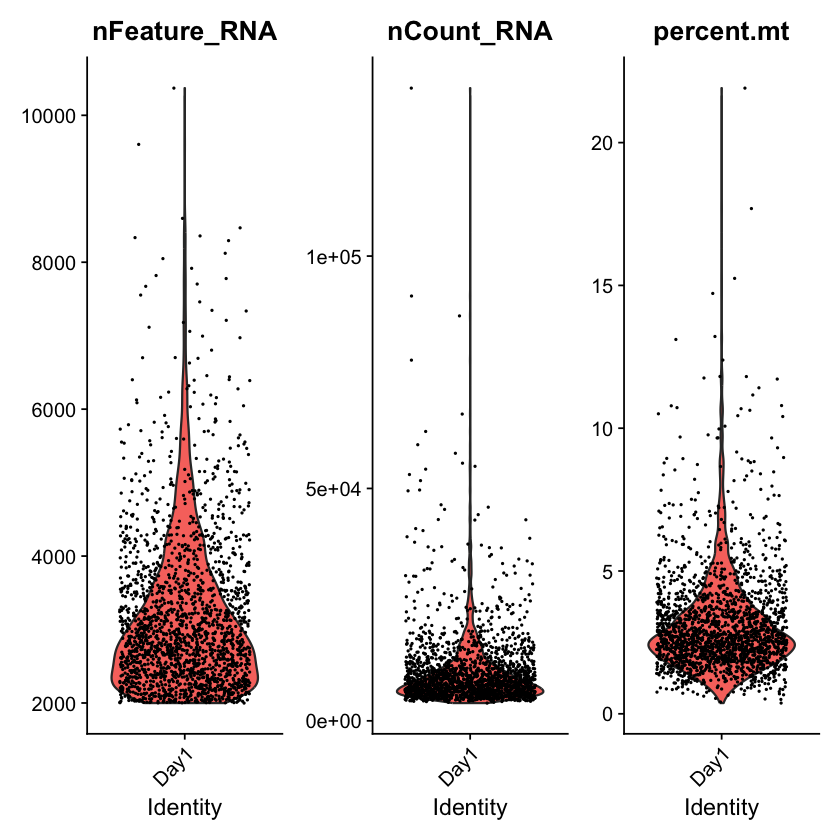

In [54]:
# Visualize QC metrics as a violin plot
# Start here to see the general trend of RNA and Counts
Vln_plots1 = VlnPlot(day1_Seurat1, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
print(Vln_plots1)

In [28]:
pdf(file = "../Day1/figures/Day1_violin_plots.pdf",
    width = 10,
    height = 10)
print(Vln_plots1)
dev.off()

agg_record_1397602676 
                    2

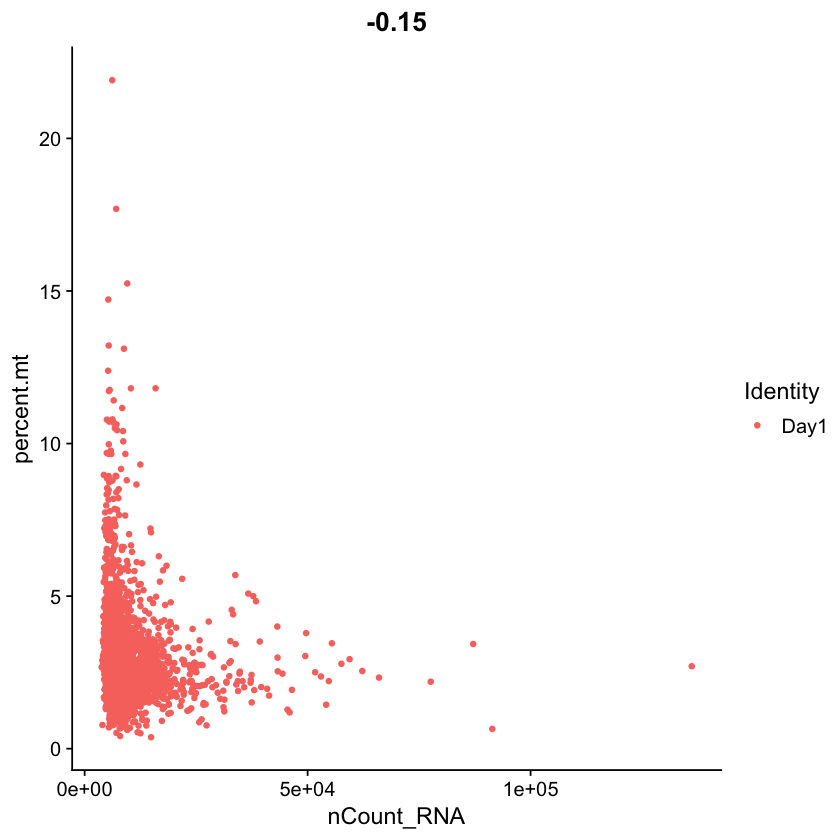

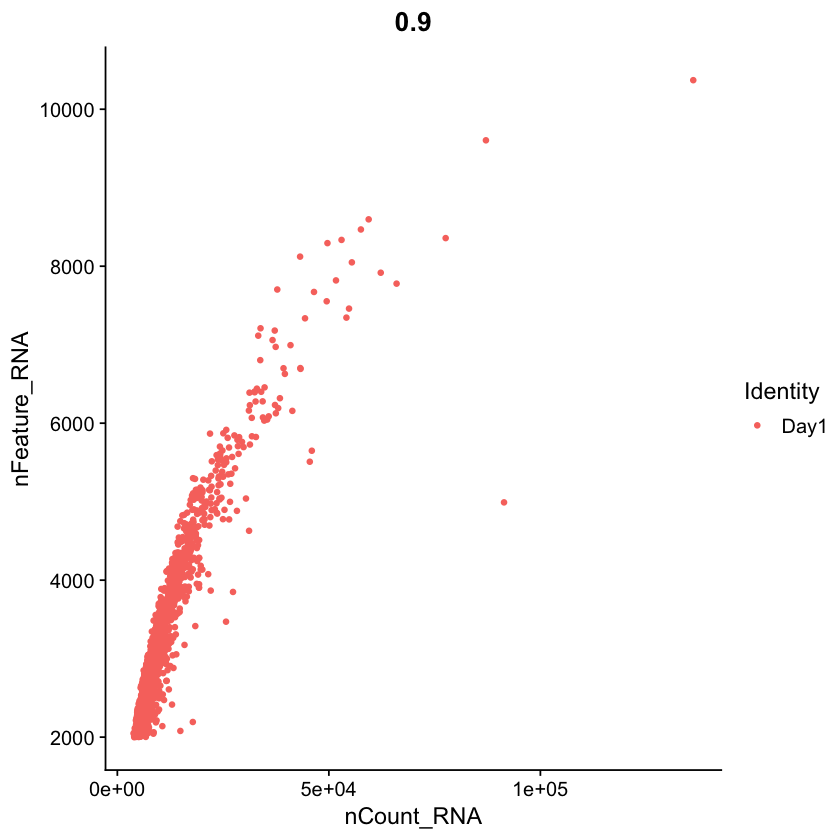

In [36]:
# FeatureScatter is typically used to visualize feature-feature 
# relationships, but can be used for anything calculated by the 
# object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(day1_Seurat1, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(day1_Seurat1, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
print(plot1)
print(plot2)

In [55]:
# Gather cells samples that have more than 200 genes and less than 5,000. 
# Anything less is most likely empty, anything higher than 5,000 most 
# likely contains more than one cell.
# Remove any cells that have more than 10 percent mitochondrial 
# counts as these are likely artifacts. Cell membrane is compromised 
# or mRNA leakage where only the mitochondrial mRNA remains
day1_Seurat2 <- subset(day1_Seurat1, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 10)

### Normalize the data

In [56]:
day1_Seurat3 = NormalizeData(object = day1_Seurat2, normalization.method = "LogNormalize", scale.factor = 10000)

Normalizing layer: counts



### Identification of highly variable features

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


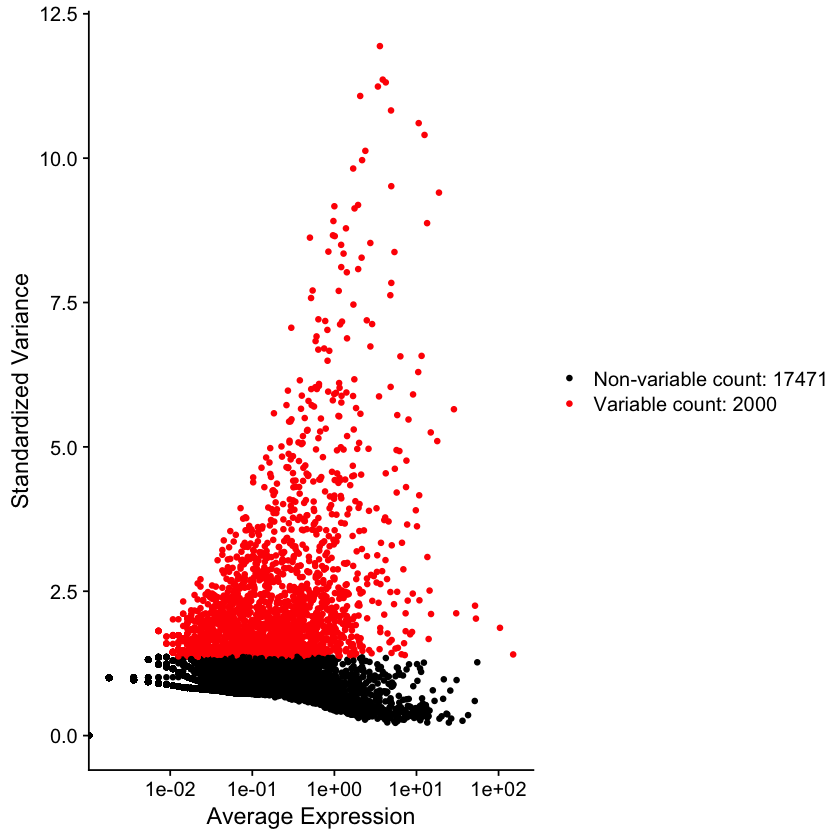

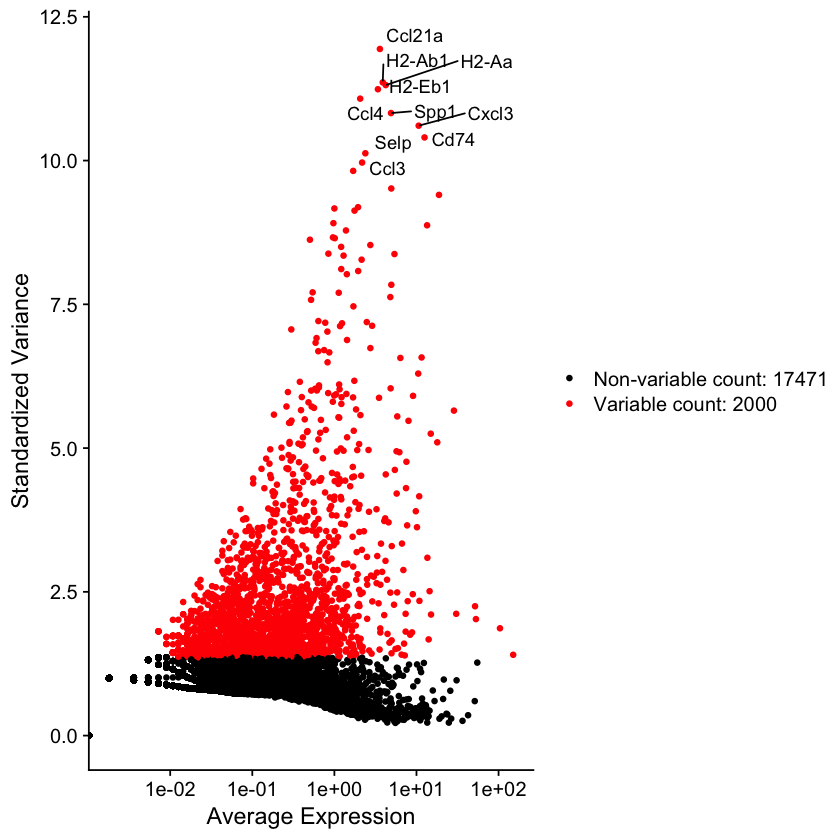

In [57]:
day1_Seurat3 = FindVariableFeatures(day1_Seurat3, selection.method = "vst", nfeatures = 2000)

#plot the top 10 features
top10 = head(VariableFeatures(day1_Seurat3),10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(day1_Seurat3)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
print(plot1)
print(plot2)

In [49]:
pdf(file = "../Day1/figures/Day1_top_10_VE_genes.pdf",
    width = 10,
    height = 10)
print(plot2)
dev.off()

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


agg_record_1632225031 
                    2

In [48]:
#save the top 10 VE genes with their p values
hvf_info = HVFInfo(day1_Seurat3)
top10_genes = head(VariableFeatures(day1_Seurat3), 10)

top10_df = hvf_info[top10_genes, ] %>%
                                  tibble::rownames_to_column(var = "gene")
print(top10_df)
write.csv(top10_df, file = "../Day1/results/top_10_VE_genes_day_1.csv", row.names = FALSE)

     gene      mean   variance variance.expected variance.standardized
1  Ccl21a  3.584532  462.48834         19.163392             11.940673
2  H2-Ab1  3.883094  260.34847         22.073723             11.360156
3   H2-Aa  4.226619  302.03504         25.661694             11.312283
4  H2-Eb1  3.390288  218.25641         17.374005             11.240446
5    Ccl4  2.062950  103.47891          7.361718             11.076925
6    Spp1  4.897482  881.87596         33.405584             10.826125
7   Cxcl3 10.640288 1549.31542        139.831578             10.606791
8    Cd74 12.534173 2020.32135        190.974723             10.402039
9    Selp  2.383094   95.72144          9.419982             10.126731
10   Ccl3  2.176259  114.92023          8.063979              9.965477


### Scaling the data

In [76]:
all.genes = rownames(day1_Seurat3)
day1_Seurat4 = ScaleData(day1_Seurat3, features = all.genes)

Centering and scaling data matrix



In [77]:
# Remove unwanted sources of variation from a single-cell dataset such as mitochondrial contamination.
day1_Seurat4 <- ScaleData(day1_Seurat4, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix

Warning message:
“Different features in new layer data than already exists for scale.data”


### Perform linear dimensional reduction

In [78]:
day1_Seurat5 = RunPCA(day1_Seurat4, features = VariableFeatures(object = day1_Seurat4))

PC_ 1 
Positive:  Fcer1g, Tyrobp, Ctss, Lyz2, Cd53, Alox5ap, Ccl9, Lcp1, Ccl6, Itgam 
	   Laptm5, Ms4a6c, Plek, Cd14, Spi1, Il1b, C5ar1, Cotl1, Csf1r, Fcgr3 
	   Cfp, Ms4a6d, Cd68, Lilrb4a, Thbs1, Fcgr1, Msr1, Mpeg1, Cd52, Pirb 
Negative:  Sparc, Igfbp7, Plpp3, Bgn, Serping1, Igfbp4, Cebpd, Col1a2, Dcn, Mgp 
	   Timp3, Col3a1, Col1a1, Col5a2, Pmp22, Il11ra1, Mmp2, Col4a1, Col6a1, Serpinf1 
	   Nbl1, Fbln1, Ebf1, C1s1, S100a16, Gsn, Adamts1, Ramp2, Rarres2, Lum 
PC_ 2 
Positive:  Egfl7, Pecam1, Cdh5, Ecscr, Rasip1, Ctla2a, Emcn, Lrg1, Cyyr1, Pdlim1 
	   Podxl, F11r, Flt1, Mmrn2, Epas1, Sdpr, Adgrg1, Esam, Ptprb, Kdr 
	   Plvap, Apold1, Tm4sf1, Spint2, Eng, Tie1, Gimap6, Tspan13, Bcam, Tinagl1 
Negative:  Col1a2, Col1a1, Gsn, Serpinf1, Mmp2, Col3a1, Dcn, Col6a1, Serping1, Lum 
	   Fbln1, C1s1, Il11ra1, Fn1, Gas1, Col6a2, Igfbp6, Col6a3, Col5a2, Bgn 
	   Igfbp4, Angptl1, Rarres2, Pdgfra, Cygb, Bicc1, C1ra, Ccdc80, Pcolce, Igf1 
PC_ 3 
Positive:  Lypd2, Cyp2a5, Cdh26, Tspan8, Plet1, Tmem21

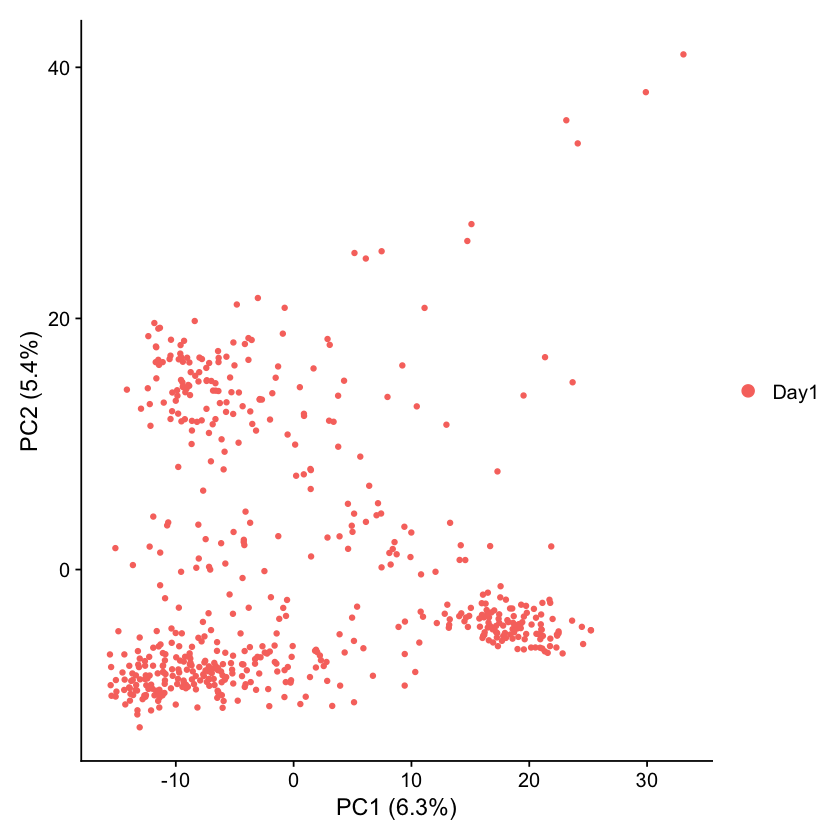

In [79]:
# To add the percent of variation explained by each component
pca_var <- Seurat::Stdev(object = day1_Seurat5, reduction = "pca")
pca_var_perc <- pca_var / sum(pca_var) * 100

pc1_perc <- round(pca_var_perc[1], 1)
pc2_perc <- round(pca_var_perc[2], 1)

PCA_plot1 = DimPlot(day1_Seurat5, reduction = "pca") +
  xlab(paste0("PC1 (", round(pca_var_perc[1],1), "%)")) +
  ylab(paste0("PC2 (", round(pca_var_perc[2],1), "%)"))
print(PCA_plot1)

In [80]:
pdf(file = "../Day1/figures/Day1_PCA.pdf",
    width = 10,
    height = 10)
print(PCA_plot1)
dev.off()

agg_record_96143414 
                  2

### Determine the dimensionality of the dataset

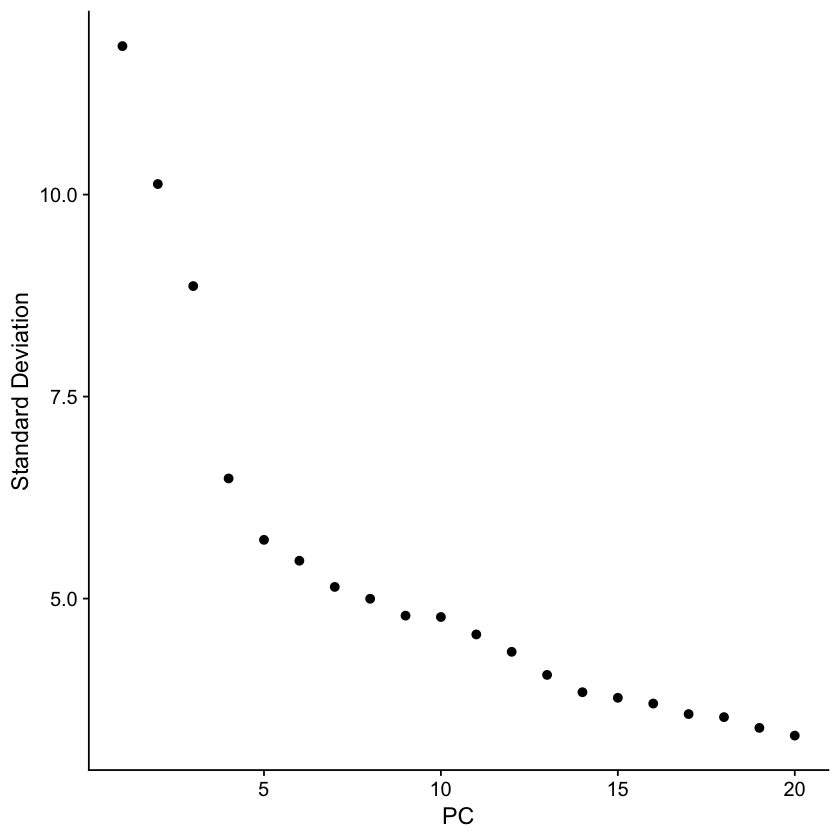

In [62]:
ElbowPlot(day1_Seurat5)

### Cluster the cells

In [69]:
# resolution
# Value of the resolution parameter, use a value above (below) 
# 1.0 if you want to obtain a larger (smaller) number of communities.

day1_Seurat5 = FindNeighbors(day1_Seurat5, dims = 1:50)
day1_Seurat5 = FindClusters(day1_Seurat5, resolution = c(0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 556
Number of edges: 17485

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9081
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 556
Number of edges: 17485

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8458
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 556
Number of edges: 17485

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8049
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 556
Number of edges: 17485

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7652
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer version

In [64]:
head(Idents(day1_Seurat5), 5)

AAACCCATCGCTATTT-1 AAACGAAGTAACTTCG-1 AAACGAATCCCAAGTA-1 AAACGCTGTCAGGCAA-1 
                 8                 13                  1                  1 
AAATGGACAAATACGA-1 
                 7 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13

### Run non-linear dimensional reduction, UMAP

In [70]:
day1_Seurat5 = RunUMAP(day1_Seurat5, dims = 1:50)

10:44:00 UMAP embedding parameters a = 0.9922 b = 1.112

10:44:00 Read 556 rows and found 50 numeric columns

10:44:00 Using Annoy for neighbor search, n_neighbors = 30

10:44:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:44:00 Writing NN index file to temp file /var/folders/t9/tm6czqy15131vrjm3_cwgw9h0000gp/T//Rtmpo8KKJa/file7a37e59db70

10:44:00 Searching Annoy index using 1 thread, search_k = 3000

10:44:00 Annoy recall = 100%

10:44:00 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

10:44:00 Initializing from normalized Laplacian + noise (using RSpectra)

10:44:00 Commencing optimization for 500 epochs, with 21070 positive edges

10:44:00 Using rng type: pcg

10:44:01 Optimization finished



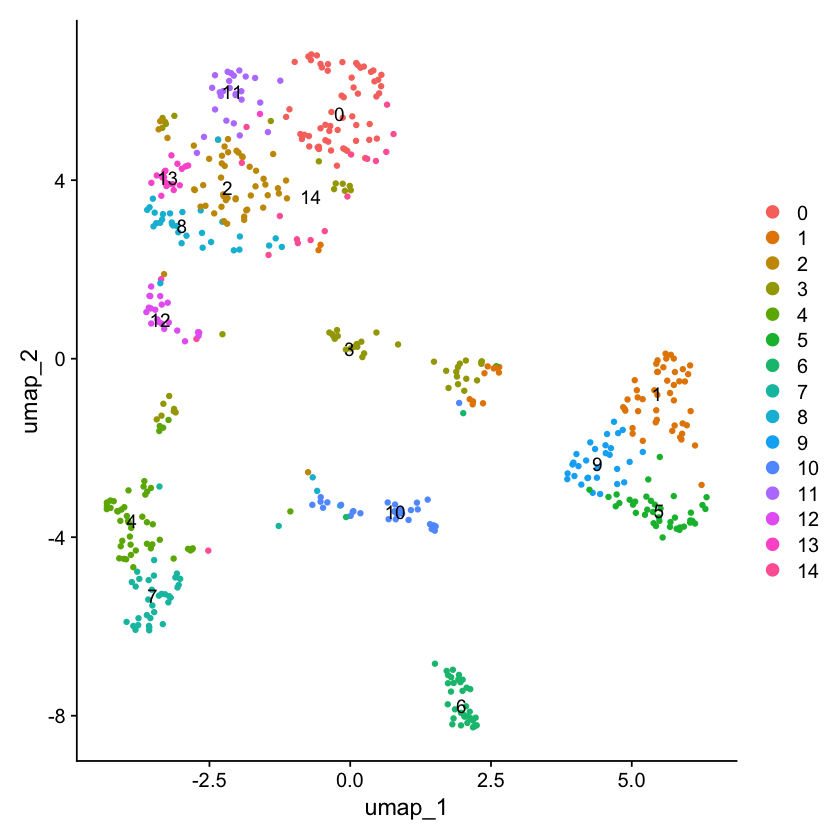

In [71]:
UMAP_plot1 = DimPlot(day1_Seurat5, reduction = "umap", label = TRUE)
print(UMAP_plot1)

In [72]:
pdf(file = "../Day1/figures/Day1_UMAP_plot.pdf",
    width = 10,
    height = 10)
print(UMAP_plot1)
dev.off()

agg_record_1923904026 
                    2

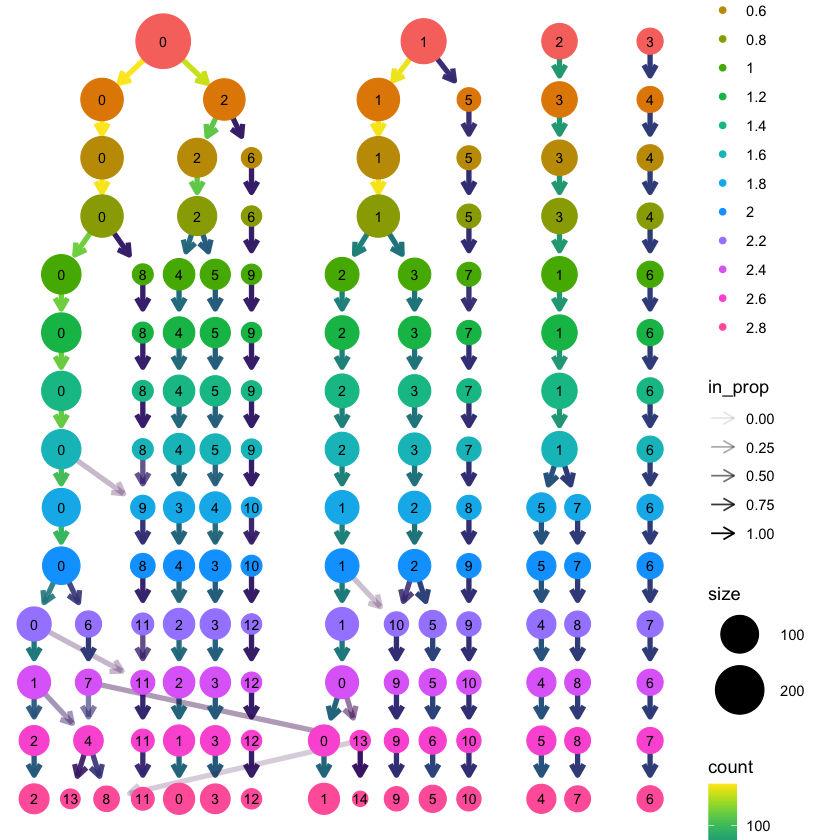

In [73]:
phylo_tree1 = clustree(day1_Seurat5, prefix = "RNA_snn_res.")
print(phylo_tree1)

In [74]:
pdf(file = "../Day1/figures/Day1_phylogenetic_tree.pdf",
    width = 10,
    height = 10)
print(phylo_tree1)
dev.off()

agg_record_1757909024 
                    2

In [42]:
sessionInfo()

R version 4.5.1 (2025-06-13)
Platform: aarch64-apple-darwin20
Running under: macOS Tahoe 26.0.1

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.12.1

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/Chicago
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] future_1.68.0      clustree_0.5.1     ggraph_2.2.2       ggplot2_4.0.1     
[5] patchwork_1.3.2    Seurat_5.4.0       SeuratObject_5.3.0 sp_2.2-0          
[9] dplyr_1.1.4       

loaded via a namespace (and not attached):
  [1] RColorBrewer_1.1-3     jsonlite_2.0.0         magrittr_2.0.4        
  [4] spatstat.utils_3.2-0   farver_2.1.2           ragg_1.5.0            
  [7] vctrs_0.6.5            ROCR_1.0-11    